# **SOFTMAX Modeling and Evaluation Notebook**

## Objectives

- Answer Business Requirement 2: Develop a Machine Learning model to classify cherry leaves as Healthy or Infected, enabling the prediction of powdery mildew presence.

## Inputs

Dataset
- inputs/mildew_dataset/cherry-leaves/train
- inputs/mildew_dataset/cherry-leaves/validation
- inputs/mildew_dataset/cherry-leaves/test

Precomputed Features (from Data Visualization Notebook)
- Image Shape Standardization → 128x128x3 for consistency across models.
- Class Distribution Analysis → Ensures balanced dataset splits.
- Pixel Intensity Distribution → Confirms brightness variations relevant for classification.

## Outputs

### Data Processing & Visualization
- **Dataset Distribution Plot** → Confirms balanced data split across training, validation, and test sets.  
- **Data Augmentation Visualization** → Showcases applied transformations (rotation, flipping, zooming).  

### Model Training & Evaluation
- **Baseline CNN Model** → Initial implementation for benchmarking.  
- **Hyperparameter-Tuned CNN** → Optimized model through manual adjustments.  
- **Best Model Selection** → Chooses the final model based on test accuracy and generalization ability.  
- **Saved Trained Models** → Final model stored for deployment.  

### Model Performance & Explainability
- **Learning Curves** → Visualizes loss and accuracy trends over epochs.  
- **Histograms** → Displays predicted probability distributions.  
- **Overfitting & Generalization Check** → Assesses potential overfitting using accuracy and loss gaps.  
- **Confusion Matrices** → Shows classification performance for train, validation, and test sets.  
- **Classification Reports** → Provides precision, recall, and F1-score analysis.  
- **ROC Curves** → Evaluates model performance using Receiver Operating Characteristic analysis.  
- **Business Goal Validation** → Confirms if the model meets the required accuracy threshold.  

## Additional Comments

- **Business Impact:** Enables early detection of powdery mildew, reducing manual inspection and improving monitoring.  
- **Data-Driven Improvements:** Model refinements were based on data insights, ensuring balanced class distribution.  
- **Deployment:** The optimized model is ready for Streamlit integration for real-world use.  



---

# Set Data Directory

---

## Import Necessary Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspaces/mildew-detector')
print("You set a new current directory")

You set a new current directory


In [4]:
import os

os.chdir(os.getcwd())  # Set the working directory to the current one
print("Current directory set to:", os.getcwd())

Current directory set to: /workspaces/mildew-detector


#### Confirm the new current directory

In [5]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew-detector'

## Set Input Directories

In [6]:
# Set input directories
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

## Set Output Directory

In [7]:
version = "draft_softmax"
file_path = f"outputs/{version}"

if "outputs" in os.listdir(work_dir) and version in os.listdir(work_dir + "/outputs"):
    print("Old version is already available create a new version.")
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set Label Names

In [8]:
# Set the labels for the images
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['Healthy', 'Infected']


## Set Image Shape

In [9]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(128, 128, 3)

---

## Number of Images in Train, Test and Validation Data

In [10]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define dataset folders
folders = ['train', 'validation', 'test']

# Loop through each dataset split and count images
for folder in folders:
    for label in labels:
        path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(path)) if os.path.exists(path) else 0  
        data['Set'].append(folder)
        data['Label'].append(label)
        data['Frequency'].append(num_images)
        print(f" {folder}/{label}: {num_images} images")

# Convert dictionary to DataFrame
df_freq = pd.DataFrame(data)

 train/Healthy: 1472 images
 train/Infected: 1472 images
 validation/Healthy: 210 images
 validation/Infected: 210 images
 test/Healthy: 422 images
 test/Infected: 422 images


### Bar Chart - Image Distribution

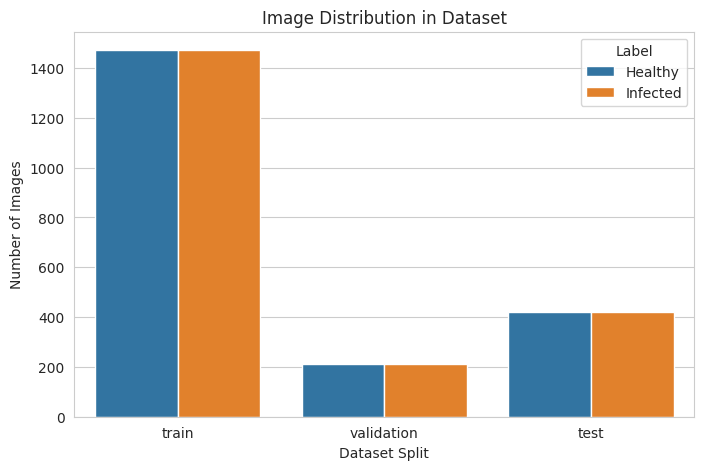

In [11]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution in Dataset")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Implement Data Augmentation

---

### ImageDataGenerator

In [12]:
# Import TensorFlow/Keras ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-03-01 08:13:00.721160: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 08:13:01.911514: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Augment Training, Validation, and Test Sets

- Initialize ImageDataGenerator for Data Augmentation

In [13]:
# Define Augmentation for Training Set
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

- Augment Training Image Dataset

In [14]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Validation Image Dataset

In [15]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Test Image Dataset

In [16]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

---

## Visualization of Augmented Images

### Plot Augmented Training Image

(20, 128, 128, 3)


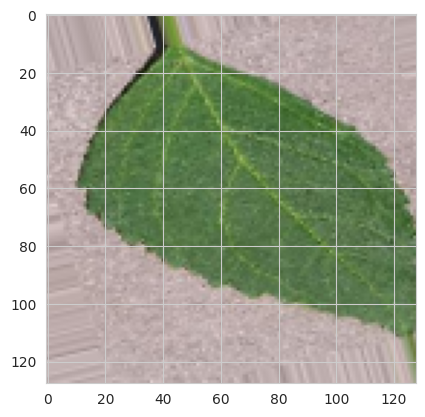

(20, 128, 128, 3)


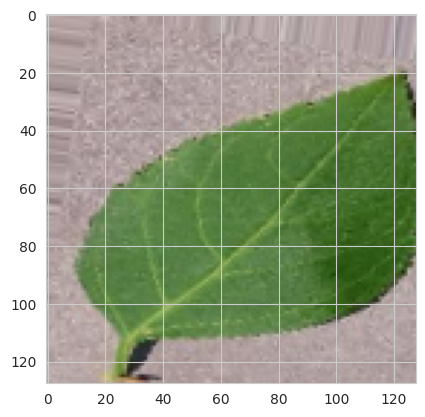

(20, 128, 128, 3)


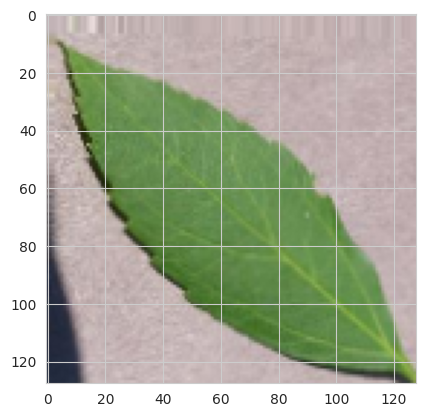

In [17]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot Augmented Validation and Test Images

(20, 128, 128, 3)


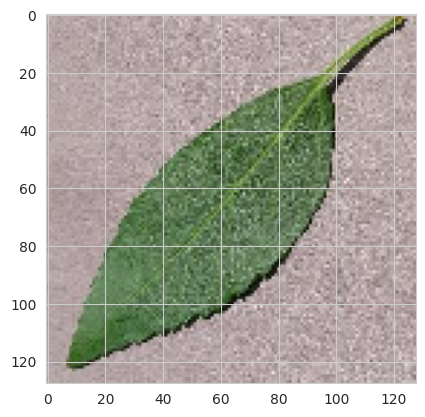

(20, 128, 128, 3)


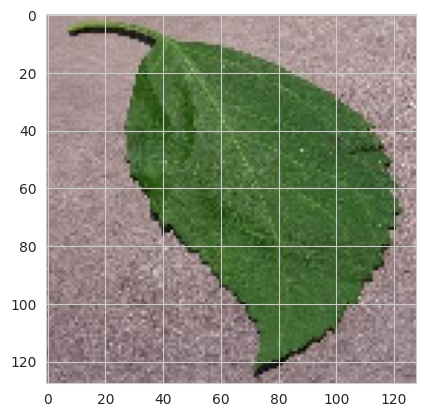

(20, 128, 128, 3)


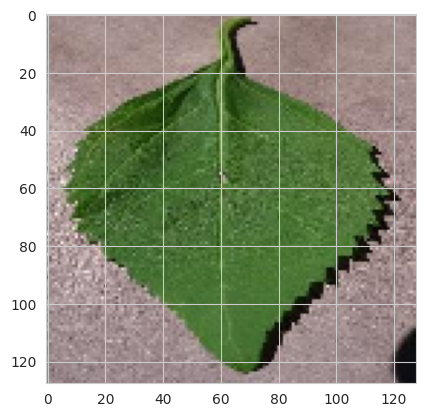

In [18]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 128, 128, 3)


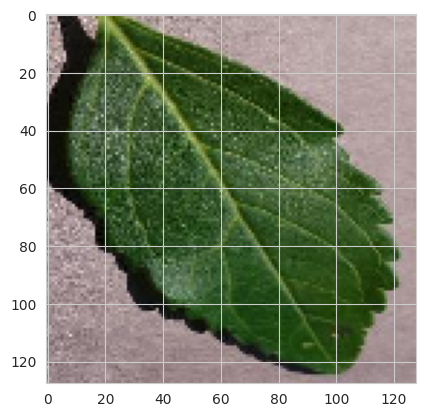

(20, 128, 128, 3)


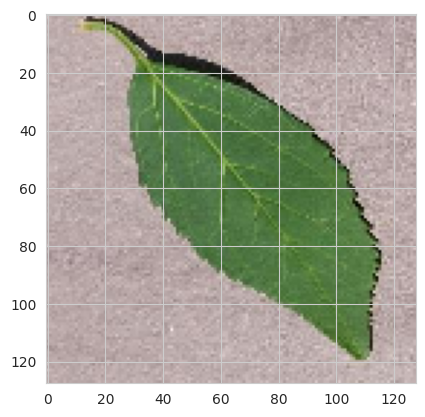

(20, 128, 128, 3)


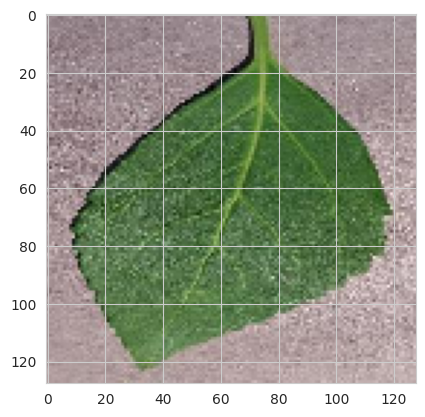

In [19]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [20]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/draft_softmax/class_indices.pkl']

### Compare Multiple Augmented Images in a Grid

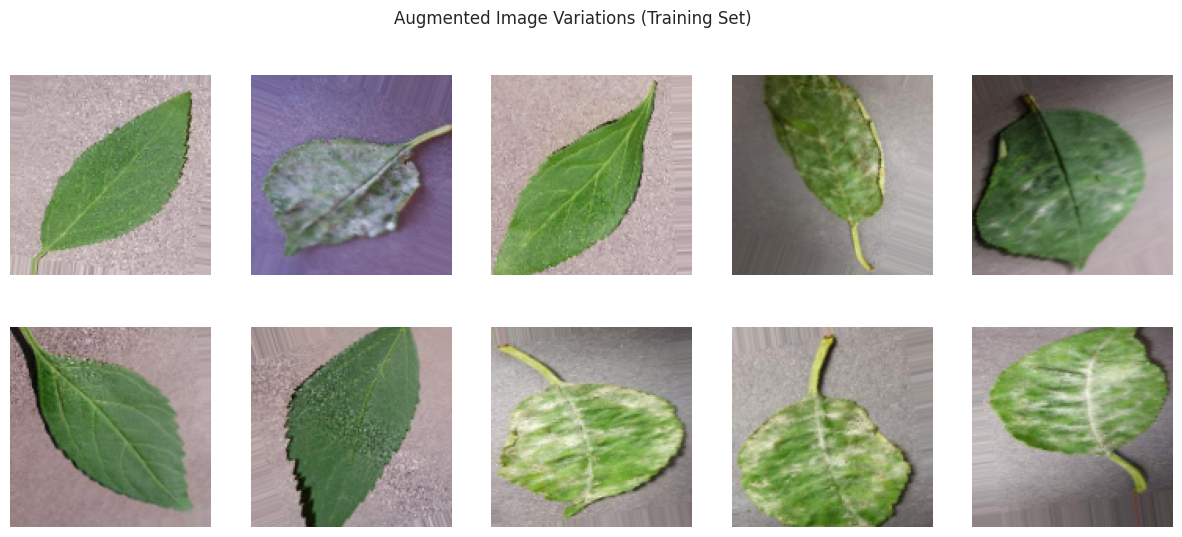

In [21]:
def plot_augmented_images_grid(data_generator, num_images=10):
    """Displays a grid of augmented images to visualize transformation effects."""
    img_batch, label_batch = next(data_generator)

    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))
    
    for i in range(num_images):
        ax = axes[i // (num_images // 2), i % (num_images // 2)]
        ax.imshow(img_batch[i])
        ax.axis("off")

    plt.suptitle("Augmented Image Variations (Training Set)")
    plt.show()

# Display the augmented image grid
plot_augmented_images_grid(train_set)

---

# Model Creation

---

### Import Libraries

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input  
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adagrad

## Convolutional Neural Network with Softmax

In [23]:
# Create Softmax CNN Model 2nd Trial
model_softmax = Sequential(
    [
        Input(shape=(128, 128, 3)),
        Conv2D(16, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(2, activation="softmax"),  # Softmax for binary classification
    ]
)

# Compile Model
model_softmax.compile(
    optimizer=Adagrad(learning_rate=0.005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

### Model Summary 

In [24]:
# Print model summary
model_softmax.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,602 (6.22 MB)

 Trainable params: 1,629,602 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Save Softmax model summary to a text file
with open("outputs/draft_softmax/model_summary.txt", "w") as f:
    model_softmax.summary(print_fn=lambda x: f.write(x + "\n"))

---

## Model Training

### Early Stopping Implementation

In [26]:
# Import required callbacks
from tensorflow.keras.callbacks import EarlyStopping

# Set EarlyStopping callback
early_stop = EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

### Fit CNN Model for Training

In [27]:
# Train the Softmax CNN Model
history_softmax = model_softmax.fit(
    train_set,  # Ensure consistency with Sigmoid model
    epochs=10,
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_data=validation_set,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10


/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.7008 - loss: 0.5672 - val_accuracy: 0.8500 - val_loss: 0.3667
Epoch 2/10
  1/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.6000 - loss: 0.6848

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6000 - loss: 0.6848 - val_accuracy: 0.7595 - val_loss: 0.4456
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.8623 - loss: 0.3311 - val_accuracy: 0.9500 - val_loss: 0.1847
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8000 - loss: 0.3050 - val_accuracy: 0.9452 - val_loss: 0.1856
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.9142 - loss: 0.2372 - val_accuracy: 0.9619 - val_loss: 0.1174
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0679 - val_accuracy: 0.9619 - val_loss: 0.1180
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9587 - loss: 0.1303 - val_accuracy: 0.9881 - val_loss: 0.0675
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9500 - loss: 0.1328 - val_accuracy: 0.9762 - val_loss: 0.0724
Epoch 9/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.9723 - loss: 0.0989 - val_accuracy: 0

### Save the Best Model

In [32]:
import os

# Define file paths
model_path = "outputs/draft_softmax/mildew_detector_softmax.keras"

# Delete existing file if it exists
if os.path.exists(model_path):
    os.remove(model_path)

# Save model in `.keras` format (better for trials)
model_softmax.save(model_path)

---

# Model Performance & Evaluation

---

### Import Packages

In [33]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
)

### Load Saved Model

In [35]:
from keras.models import load_model

model = load_model("outputs/draft_softmax/mildew_detector_softmax.keras") 

## Model Evaluation

In [36]:
## Model Evaluation
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ", evaluation[0])

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9892 - loss: 0.0409
Model accuracy: 99.17%
Model Loss:  0.03471393138170242


## Set Accuracy Variables

In [37]:
# Correctly obtain true labels
y_true = test_set.labels

# Obtain model predictions
preds = model.predict(test_set)
y_pred = np.argmax(preds, axis=1)  

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


## Save Training History

In [38]:
df_history_softmax = pd.DataFrame(history_softmax.history)
df_history_softmax.to_csv("outputs/draft_softmax/history_softmax.csv", index=False)
print("Softmax CNN training history saved.")

Softmax CNN training history saved.


## Learning Curves

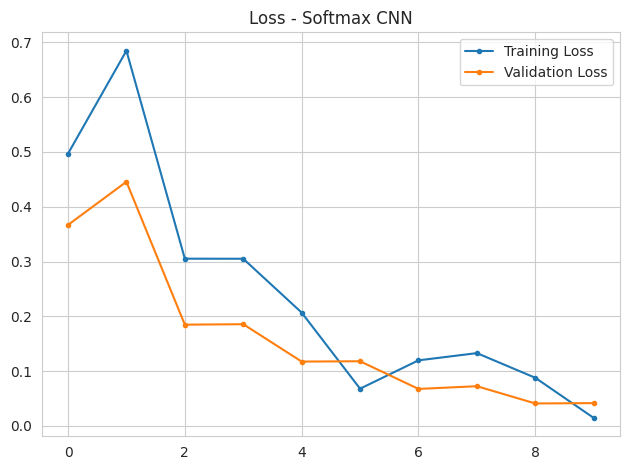

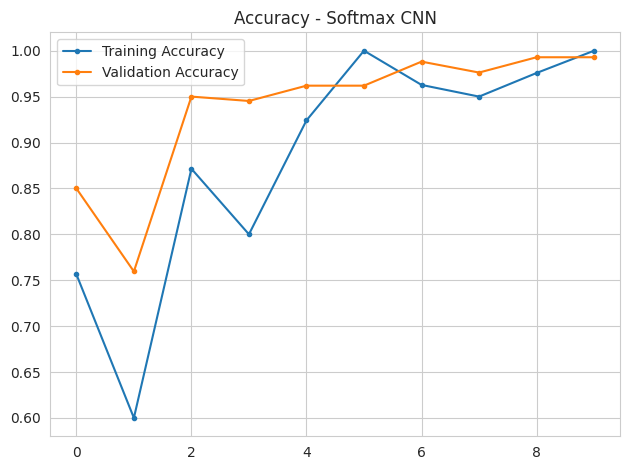

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

output_dir = "outputs/draft_softmax"

# Set Seaborn style
sns.set_style("whitegrid")

# Loss Curve
df_history_softmax[["loss", "val_loss"]].plot(style=".-")
plt.title("Loss - Softmax CNN")
plt.legend(["Training Loss", "Validation Loss"])
plt.grid(True)
plt.tight_layout()
plt.savefig("outputs/draft_softmax/model_training_losses.png", bbox_inches="tight", dpi=150)
plt.show()

# Accuracy Curve
df_history_softmax[["accuracy", "val_accuracy"]].plot(style=".-")
plt.title("Accuracy - Softmax CNN")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.grid(True)
plt.tight_layout()
plt.savefig("outputs/draft_softmax/model_training_acc.png", bbox_inches="tight", dpi=150)
plt.show()

## Histograms

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


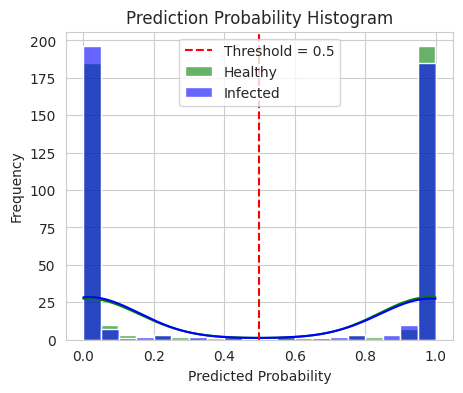

In [40]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

output_dir = "outputs/draft_softmax"

# Get predicted probabilities
y_pred_probs = model_softmax.predict(validation_set)

# Plot histogram
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
sns.histplot(
    y_pred_probs[:, 0], bins=20, kde=True, color="green", alpha=0.6, label="Healthy"
)
sns.histplot(
    y_pred_probs[:, 1],
    bins=20,
    kde=True,
    color="blue",
    alpha=0.6,
    label="Infected",
)

plt.axvline(x=0.5, color="red", linestyle="dashed", label="Threshold = 0.5")
plt.title("Prediction Probability Histogram")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()

# Save figure
plt.savefig("outputs/draft_softmax/histogram_test.png", bbox_inches="tight", dpi=150)
plt.show()

## Overfitting & Generalization Check

In [41]:
# Extract the last recorded training & validation metrics
train_acc = history_softmax.history["accuracy"][-1]
val_acc = history_softmax.history["val_accuracy"][-1]
train_loss = history_softmax.history["loss"][-1]
val_loss = history_softmax.history["val_loss"][-1]

# Compute Generalization Gap
accuracy_gap = train_acc - val_acc
loss_gap = (
    val_loss - train_loss
)  

print("\n### Generalization & Overfitting Check ###")
print(f"Final Train Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Accuracy Gap: {accuracy_gap:.4f}")

print(f"Final Train Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Loss Gap: {loss_gap:.4f}")

# Overfitting Analysis
if accuracy_gap > 0.05:
    print(
        "\nOverfitting detected: The model performs significantly better on training data than validation data."
    )

if loss_gap > 0.05:
    print(
        "\nOverfitting detected: Validation loss is significantly higher than training loss."
    )

if accuracy_gap < 0.05 and loss_gap < 0.05:
    print("\nNo significant overfitting detected. Model generalizes well.")


### Generalization & Overfitting Check ###
Final Train Accuracy: 1.0000
Final Validation Accuracy: 0.9929
Accuracy Gap: 0.0071
Final Train Loss: 0.0145
Final Validation Loss: 0.0416
Loss Gap: 0.0270

No significant overfitting detected. Model generalizes well.


## Confusion Matrix 

148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


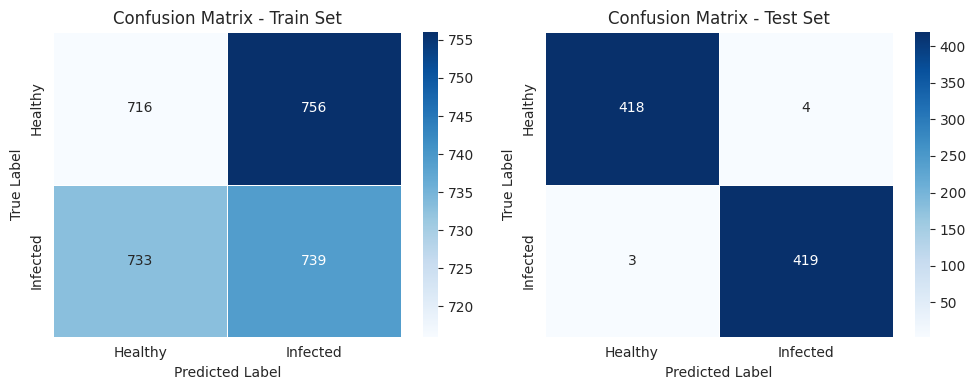

Confusion Matrices saved at: outputs/draft_softmax/confusion_matrices_train_test.png


In [42]:
from sklearn.metrics import confusion_matrix
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


output_dir = "outputs/draft_softmax"

# Get Class Labels
label_map = list(test_set.class_indices.keys())

# Evaluate Model on Train and Test Sets
y_true_train = train_set.classes
y_pred_train = np.argmax(model_softmax.predict(train_set), axis=1)

y_true_test = test_set.classes
y_pred_test = np.argmax(model_softmax.predict(test_set), axis=1)

# Generate Confusion Matrices
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Plot Confusion Matrices Side by Side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(
    pd.DataFrame(cm_train, index=label_map, columns=label_map),
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    ax=axes[0],
)
axes[0].set_title("Confusion Matrix - Train Set")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(
    pd.DataFrame(cm_test, index=label_map, columns=label_map),
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    ax=axes[1],
)
axes[1].set_title("Confusion Matrix - Test Set")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()

# Save Figure
save_path = os.path.join(output_dir, "confusion_matrices_train_test.png")
plt.savefig(save_path, dpi=150)
plt.show()

print(f"Confusion Matrices saved at: {save_path}")

## Classification Reports

In [43]:
from sklearn.metrics import classification_report
import os


output_dir = "outputs/draft_softmax"

# Generate classification reports as text
report_train = classification_report(y_true_train, y_pred_train, target_names=label_map, digits=3)
report_test = classification_report(y_true_test, y_pred_test, target_names=label_map, digits=3)

# Print side by side
print("\n### Classification Reports (Train vs Test) ###\n")
train_lines = report_train.split("\n")
test_lines = report_test.split("\n")

# Align Train and Test reports side by side
for train_line, test_line in zip(train_lines, test_lines):
    print(f"{train_line:<40} | {test_line}")

# Save reports as text files
with open(f"{output_dir}/classification_report_train.txt", "w") as f:
    f.write(report_train)

with open(f"{output_dir}/classification_report_test.txt", "w") as f:
    f.write(report_test)

print("\nReports saved to outputs/draft_softmax/")


### Classification Reports (Train vs Test) ###

              precision    recall  f1-score   support |               precision    recall  f1-score   support
                                         | 
     Healthy      0.494     0.486     0.490      1472 |      Healthy      0.993     0.991     0.992       422
    Infected      0.494     0.502     0.498      1472 |     Infected      0.991     0.993     0.992       422
                                         | 
    accuracy                          0.494      2944 |     accuracy                          0.992       844
   macro avg      0.494     0.494     0.494      2944 |    macro avg      0.992     0.992     0.992       844
weighted avg      0.494     0.494     0.494      2944 | weighted avg      0.992     0.992     0.992       844
                                         | 

Reports saved to outputs/draft_softmax/


## ROC Curves

148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


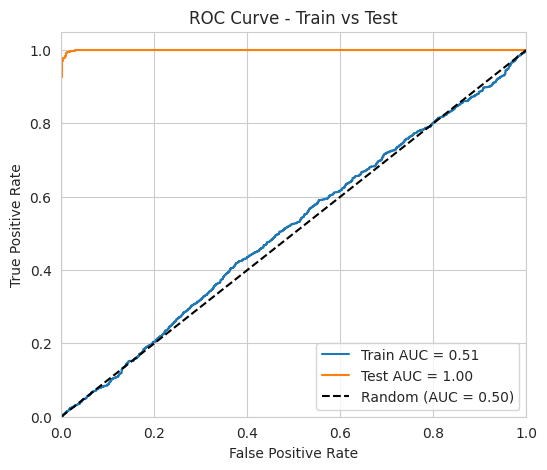

ROC Curve saved at: outputs/draft_softmax/roc_curve.png


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os

# Ensure output directory exists
output_dir = "outputs/draft_softmax"
os.makedirs(output_dir, exist_ok=True)

# Generate predictions (probabilities)
y_probs_train = model_softmax.predict(train_set)
y_probs_test = model_softmax.predict(test_set)

# Compute ROC curve
fpr_train, tpr_train, _ = roc_curve(y_true_train, y_probs_train[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_true_test, y_probs_test[:, 1])

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC Curves
plt.figure(figsize=(6, 5))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.2f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.50)")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Train vs Test")
plt.legend(loc="lower right")

# Save figure
roc_curve_path = os.path.join(output_dir, "roc_curve.png")
plt.savefig(roc_curve_path, dpi=150)
plt.show()

print(f"ROC Curve saved at: {roc_curve_path}")

## Save Final Evaluation Results

In [45]:
import joblib
import os
from sklearn.metrics import classification_report, confusion_matrix

output_dir = "outputs/draft_softmax"

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_set, batch_size=batch_size)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get True Labels & Predictions
y_true = test_set.classes
y_pred_probs = model.predict(test_set)
y_pred = np.argmax(y_pred_probs, axis=1)

# Save evaluation results
evaluation_results = {
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "classification_report": classification_report(
        y_true, y_pred, target_names=label_map, output_dict=True
    ),
    "confusion_matrix": confusion_matrix(y_true, y_pred),
}

# Save to pickle file
joblib.dump(evaluation_results, "outputs/draft_softmax/evaluation.pkl")
print("Evaluation results saved: outputs/draft_softmax/evaluation.pkl")

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9892 - loss: 0.0409
Test Accuracy: 0.9917
Test Loss: 0.0347
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Evaluation results saved: outputs/draft_softmax/evaluation.pkl


## Business Goal Validation

In [46]:
# Define minimum required accuracy
accuracy_threshold = 0.90

# Load evaluation results
evaluation_results = joblib.load("outputs/draft_softmax/evaluation.pkl")

# Extract final test accuracy
test_accuracy = evaluation_results["test_accuracy"]

# Check requirement
if test_accuracy >= accuracy_threshold:
    print(f"Model meets the business requirement! (Accuracy: {test_accuracy:.2%})")
else:
    print(f"Model does NOT meet the requirement. (Accuracy: {test_accuracy:.2%})")

Model meets the business requirement! (Accuracy: 99.17%)


---

# Predict on New Images

---

## Load the Final Model

In [47]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [48]:
# Load the Model
model = load_model("outputs/draft_softmax/mildew_detector_softmax.keras")

### Select and Load a Random Test Image

Selected Image Path: inputs/mildew_dataset/cherry-leaves/test/Infected/a1b8deb6-ef70-4d87-8fea-188a2d84b240___FREC_Pwd.M 5069.JPG
Image shape: (128, 128), Image mode: RGB


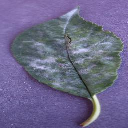

In [49]:
# Define test image selection parameters
pointer = 60  # Change this number to select a different image
label = labels[1]  # Select "Healthy" (0) or "Infected" (1)

# Load the image using PIL
img_path = test_path + "/" + label + "/" + os.listdir(test_path + "/" + label)[pointer]
pil_image = image.load_img(img_path, target_size=image_shape, color_mode="rgb")

# Display image details
print(f"Selected Image Path: {img_path}")
print(f"Image shape: {pil_image.size}, Image mode: {pil_image.mode}")

# Show the image
pil_image



### Convert Image to Array and Prepare for Model Input

In [50]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0) / 255.0  # Normalize pixel values
print(my_image.shape)

(1, 128, 128, 3)


### Make Prediction & Display Result

In [51]:
# Predict class probabilities
pred_proba = model.predict(my_image)[0, 0]  # Extract single probability score

# Map indices to class labels
target_map = {v: k for k, v in train_set.class_indices.items()}  # Reverse mapping
pred_class = target_map[int(pred_proba > 0.5)]  # Ensure correct label mapping

# Adjust probability if necessary
if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

# Print prediction results
print(f"Predicted Class: {pred_class}")
print(f"Prediction Probability: {pred_proba:.4f}")

# Save the image to outputs/draft for PDF report
os.makedirs("outputs/draft_sofmax", exist_ok=True)
pil_image.save("outputs/draft_softmax/selected_test_image.png")

# Save prediction results as a text file
with open("outputs/draft_softmax/prediction_result.txt", "w") as f:
    f.write(f"Predicted Class: {pred_class}\n")
    f.write(f"Prediction Probability: {pred_proba:.4f}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted Class: Healthy
Prediction Probability: 0.9985


---

# Conclusion and Next Steps

---

## Conclusion & Next Steps

We successfully developed a deep learning model for image classification using a structured, beginner-friendly approach.  

### **Key Achievements**
- **Baseline & Optimized CNNs** → Established a benchmark model and improved it through manual hyperparameter tuning.  
- **Comprehensive Evaluation** → Assessed performance using accuracy, loss, confusion matrices, and ROC curves.  
- **Model Explainability** → Utilized evaluation metrics to understand predictions and ensure reliability.  
- **Final Model Selection** → Chose the best-performing model for deployment.  

### **Next Steps: Model Deployment**
- **Web App Integration** → Implement a user-friendly Streamlit interface for real-time image classification.  
- **Model Deployment** → Load the trained model and deploy it on a cloud platform for accessibility.  

This deployment will enable efficient real-world usage, making automated classification accessible to users.  